In [1]:
using Plots, LaTeXStrings, Revise

In [2]:
using OnlineEconOPT

In [3]:
Params = ModelParams()

ModelParams(0.001, 8325, 0.000116, 70000, 1000, 10000, 0.00464, 0.0116, 0.2, Real[0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12  …  0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04], Real[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 1, 24, 0.05, 20.555555555555557, 25.0, 21.11111111111111, Real[10.0, 10.0, 10.0, 10.0], Real[7.56304948692456, 28.14513394495193, 20.199118050628325, 24.891436112480136, 11.333741309817134, 17.396493903218314, -2.1211751256069, 11.90975772273544, 26.794703706234227, 8.614997385892307  …  24.752475439012905, -2.785399916941101, -3.889750551183674, -3.102201549470692, 13.122783112653519, 27.55606138630254, 24.324559041561926, 10.352800157144626, 18.094415758778265, 29.75114982945111])

In [4]:
soln = dynamic_RT_OPT(Params);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [5]:
AchievedCost, Tᵢ_t, ϕ_h_gas_t, ϕ_h_elect_t, ϕ_c_elect_t, Tw_t = soln

(413.6566025961251, [21.11111111111111, 20.960642013849057, 20.845428159076338, 20.75566853612591, 20.689773778182833, 20.63458782682676, 20.590520131511038, 20.555555350448834, 20.555555350430417, 20.5555553504016  …  20.555555351237352, 20.555555351190865, 20.55555535113905, 20.555555351080443, 20.555555351014373, 20.555555350939617, 20.555555350855805, 20.555555350762216, 20.55555535066236, 20.555555350007428], [1.50590389912648e-8, 7.245526551249125e-7, 8.58694580677978e-7, 1.058405054577406e-6, 1.3891638990931598e-6, 2.048009807613209e-6, 4.028657497100272e-6, 118.7212660291812, 442.65773956942695, 360.73686900672607  …  3.1766924221232444e-8, 3.176729176207585e-8, 3.1767187095129356e-8, 3.176688033508664e-8, 3.176658104201883e-8, 3.1766516358246167e-8, 3.1766753015158766e-8, 3.176724197932713e-8, 3.1767465504599856e-8, 3.1767569047926655e-8], [1.0882532021266379e-8, 9.703743884544958e-8, 9.950142960289058e-8, 1.0214390746182732e-7, 1.0499761714305369e-7, 1.0810590347974484e-7, 1.

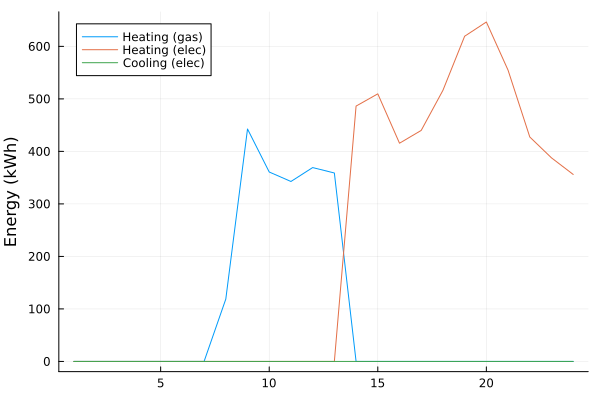

In [6]:
plot(ϕ_h_gas_t, label = "Heating (gas)")
plot!(ϕ_h_elect_t, label = "Heating (elec)")
plot!(ϕ_c_elect_t, label = "Cooling (elec)", legendfontsize=8, ylabel = "Energy (kWh)")

In [7]:
function C2F(C::Float64)
    return C * 1.8 + 32
end
function F2C(F::Float64)
    return (F - 32) / 1.8
end

F2C (generic function with 1 method)

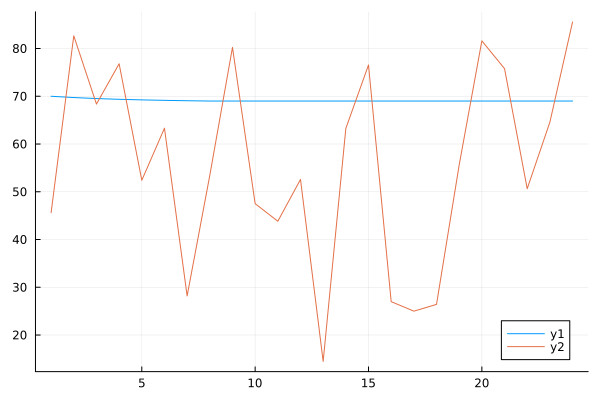

In [8]:
plot(C2F.(Tᵢ_t))
plot!(C2F.(Params.Tₐ))

In [21]:
ϕₘₐₓ = maximum([ϕ_h_elect_t; ϕ_c_elect_t])
ϕ_t = ϕ_h_elect_t .+ ϕ_c_elect_t
J = zeros(Float64, 24, 24)
function multi_dim_forwardDifference(ϵ)
    for i in 1:length(Params.Tₐ)
        Ce_i = Params.Ce
        Ce_i[i] += ϵ
        Params_i = ModelParams(;Ce = Ce_i)
        soln_i = dynamic_RT_OPT(Params_i)
        _, _, _, ϕ_h_elect_t_i, ϕ_c_elect_t_i, _ = soln_i
        ϕ_t_i = ϕ_h_elect_t_i .+ ϕ_c_elect_t_i
        J[i,:] = (ϕ_t_i .- ϕ_t) ./ ϵ
    end
    return J
end


multi_dim_forwardDifference (generic function with 1 method)

In [22]:
J = multi_dim_forwardDifference(1e-5)

24×24 Matrix{Float64}:
 -1.34726e-6  -3.77167e-6  -3.90019e-6  …      -2.84132e5       -2.90924e5
 -1.34726e-6  -1.2335e-5   -8.93123e-6      15551.6          25881.1
 -1.34726e-6  -1.01379e-5  -1.05647e-5         -2.79772e5       -2.25436e5
 -1.34726e-6  -1.01359e-5  -1.05626e-5     -24646.9          93378.6
 -1.34726e-6  -1.01868e-5  -1.06162e-5     126802.0              1.20243e5
 -1.34726e-6  -1.23182e-5  -1.2854e-5   …   77368.2          87772.0
 -1.34726e-6  -1.01895e-5  -1.0619e-5       64374.5              1.22754e5
 -1.34726e-6  -1.48117e-5  -1.5467e-5          -2.16467e5  -128886.0
 -1.34726e-6  -7.89602e-6  -8.20623e-6         -3.04125e5  -280770.0
 -1.34726e-6  -6.74373e-6  -6.99323e-6          1.54848e5    96306.7
  ⋮                                     ⋱                  
 -1.34726e-6  -7.77617e-6  -8.0809e-6   …      -2.2059e5        -1.9881e5
 -1.34726e-6  -1.0147e-5   -1.05755e-5      15798.2              1.03221e5
 -1.34726e-6  -1.01454e-5  -1.0574e-5          -1.2999

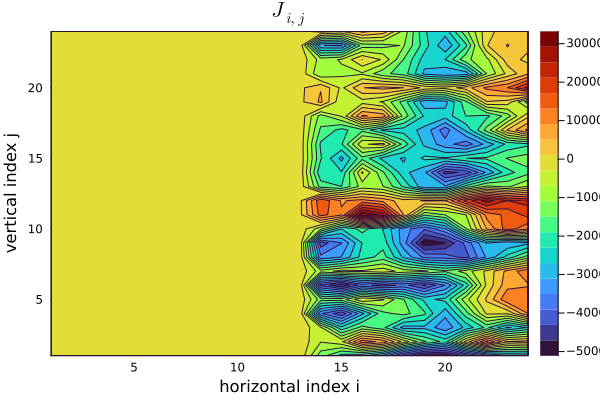

In [23]:
contourf(J, levels=20, color=:turbo)
title!(L"J_{i,j}")
xlabel!("horizontal index i")
ylabel!("vertical index j")